In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.abspath('../'))
sys.path.insert(1, os.path.abspath('../../..'))

from modules.utils import save_descriptive_stats,save_variables, significance_asterisk
from modules.config import data_reports_path, figpath, pre_color, post_color, default_color

In [3]:
data = pd.read_excel(Path('../../data/processed/relative_speed_data.xlsx'))
analysis = 'speed'
question_code = 'faster_response'
bin_columns = ['speed-<1min-delta', 'speed-1-2min-delta', 'speed-3-5min-delta',
    'speed-6-15min-delta', 'speed-16-30min-delta',
    'speed-31-60min-delta', 'speed->60min-delta']

bin_labels = [col.replace('speed-', '') for col in bin_columns]
quantitative_default = 'speed-3-5min-delta' #ego-alter-median-speed-delta'

### Compare the pre- and post-feedback assessment scores - Table 3, Figure A7

speed-Wilcoxon_Stat  282
speed-Wilcoxon_p       0.787
speed-Wilcoxon_Z      -0.265
speed-ES               0.033
speed-Zero_Diff       46.032
speed-Non-Zero_Diff   53.968
speed-pre-Mean         3.714
speed-post-Mean        3.825
speed-diff-Mean        0.111
speed-pre-Median       4
speed-post-Median      4
speed-diff-Median      0
speed-pre-Std          2.019
speed-post-Std         1.871
speed-diff-Std         1.742
speed-pre-Min          1
speed-post-Min         1
speed-diff-Min        -4
speed-pre-Max          7
speed-post-Max         7
speed-diff-Max         6


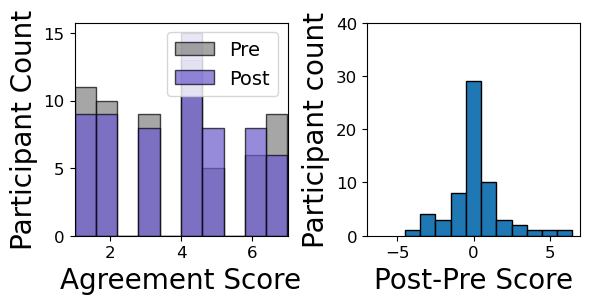

In [4]:
from modules.plots import plot_score_diff_hist
from modules.tests import calculate_wilcoxon,summarize_score_comparison
pre_scores = data[f'{question_code}_pre']
post_scores = data[f'{question_code}_post']
plot_score_diff_hist(data,question_code,analysis)
W, p_value, Z, effect_size = calculate_wilcoxon(pre_scores,post_scores)
summarize_score_comparison(analysis, question_code, data, W, p_value, Z, effect_size,display=True)
save_variables(data_reports_path,f'{analysis}-Wilcoxon-N',len(post_scores))


In [5]:
save_descriptive_stats(data_reports_path,f'{analysis}-{quantitative_default}',data[quantitative_default])

# Flag the outliers of the objective metric using the Interquartile Range (IQR) method
from modules.utils import get_outlier_bounds
lower_bound,upper_bound = get_outlier_bounds(data[{quantitative_default}])
data[f'{quantitative_default}-outlier'] = ((data[{quantitative_default}] < lower_bound) | (data[{quantitative_default}] > upper_bound)).astype(int)

### Calculate the correlations between subjective scores and the quantitative metric - Table 2 

In [8]:
from modules.tests import summarize_spearman_results,compare_correlations_zou, compare_correlations_steiger
from scipy.stats import spearmanr
from modules.plots import plot_corr_raw

# Data without the outliers
correlation_data = data[data[f'{quantitative_default}-outlier'] == 0]
sample_size = len(correlation_data)

# Mark the outliers for visualization
outlier_data = data[data[f'{quantitative_default}-outlier'] == 1]
save_variables(data_reports_path,f'{analysis}-non-outlier-N',len(correlation_data))
save_variables(data_reports_path,f'{analysis}-outlier-N',len(outlier_data))

# Quick check that counts add up to total
total_check = len(outlier_data) + len(correlation_data)
if total_check != len(data):
    raise ValueError(
        f"Outlier/non-outlier counts ({total_check}) do not add up to total data length ({len(data)}). "
        f"Possible missing or invalid values in '{quantitative_default}-outlier'.")

# Calculate the spearman correlations
results = {"pre_spearman": spearmanr(correlation_data[f'{question_code}_pre'], correlation_data[quantitative_default]),
        "post_spearman": spearmanr(correlation_data[f'{question_code}_post'], correlation_data[quantitative_default]),
        "diff_spearman": spearmanr(correlation_data[f'{question_code}_diff'], correlation_data[quantitative_default]),
        "pre_post_r": spearmanr(correlation_data[f'{question_code}_pre'].tolist(), correlation_data[f'{question_code}_post'].tolist())}

# This part of the code compares the correlation(pre-score,objective metric) with correlation(post-score, objecive metric) using two approaches

# Zou confidence interval approach
lower_zou, upper_zou = compare_correlations_zou(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size)

# Steiger's test using two-tailed and one-tailed comparisons
t_steiger2,p_steiger2 = compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=True)
t_steiger1,p_steiger1= compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=False)

# Summarize the results
summarize_spearman_results(analysis, quantitative_default, results, lower_zou, upper_zou,t_steiger2,p_steiger2,t_steiger1,p_steiger1)

+----+------------------------------------------+-----------+
|    | Metric                                   | Value     |
+====+==========================================+===========+
|  0 | speed-pre-speed-3-5min-delta-spearman-r  | 0.41      |
+----+------------------------------------------+-----------+
|  1 | speed-pre-speed-3-5min-delta-spearman-p  | 0.0011**  |
+----+------------------------------------------+-----------+
|  2 | speed-post-speed-3-5min-delta-spearman-r | 0.48      |
+----+------------------------------------------+-----------+
|  3 | speed-post-speed-3-5min-delta-spearman-p | 0.0001*** |
+----+------------------------------------------+-----------+
|  4 | speed-diff-speed-3-5min-delta-spearman-r | 0.11      |
+----+------------------------------------------+-----------+
|  5 | speed-diff-speed-3-5min-delta-spearman-p | 0.398     |
+----+------------------------------------------+-----------+
|  6 | speed-speed-3-5min-delta-zou-upper       | 0.12      |
+----+--

### Figure A8: Check if there are any subsample effects or recency effects.

The latter is checked by correlating the quantitative metric calculated based on the last donation month with the subjective scores. If the pre-post change was statistically significant, an asterisk is added on top of the result. Otherwise, the larger size of the dots indicates the significance for the pre- and post- correlations. 

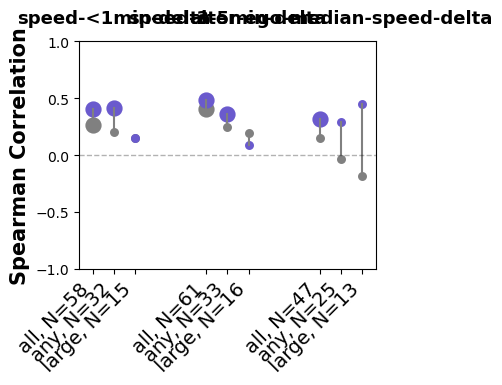

In [7]:
# Define subsets based on response differences
from modules.plots import plot_corr_differences
plot_corr_differences(data,question_code,[bin_columns[0],bin_columns[2],'alter-ego-median-speed-delta'],analysis)

### Figure A9C: Plot the correlations between the objective metric and the subjective scores for given subsamples


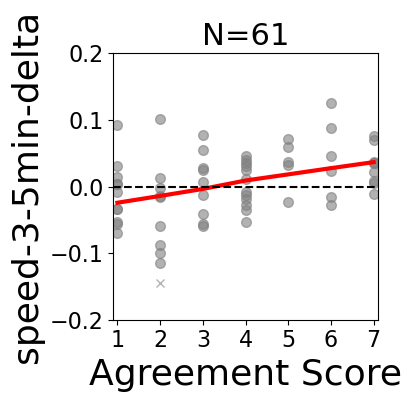

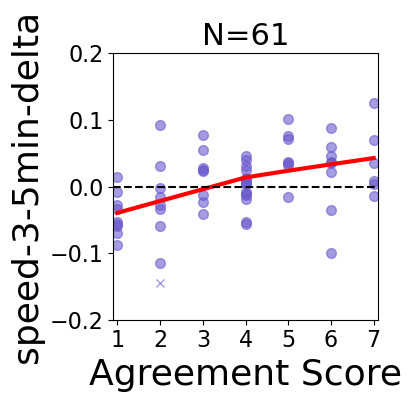

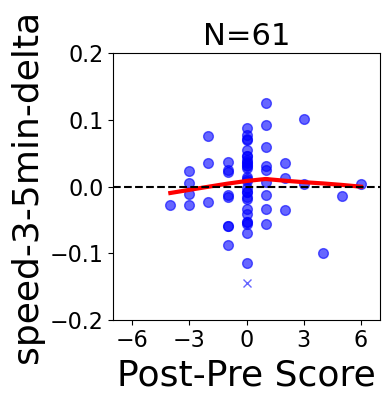

In [12]:
subsample = 'all'
sample_data = data

correlation_data = sample_data[sample_data[f'{quantitative_default}-outlier'] == 0]
outlier_data = sample_data[sample_data[f'{quantitative_default}-outlier'] == 1]

from modules.plots import plot_corr_raw
plot_corr_raw(correlation_data,outlier_data,question_code,'pre',analysis,quantitative_default,color=pre_color,label=subsample,ylim=[-0.2,0.2])
plot_corr_raw(correlation_data,outlier_data,question_code,'post',analysis,quantitative_default,color=post_color,label=subsample,ylim=[-0.2,0.2])
plot_corr_raw(correlation_data,outlier_data,question_code,'diff',analysis,quantitative_default,color=default_color,label=subsample,ylim=[-0.2,0.2])

### Fig. 5B - Correlations of pre-and post-scores with the objective metric for relative speed. 

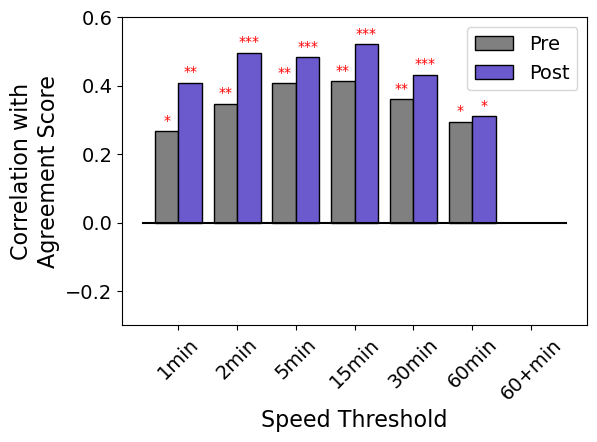

In [9]:
from modules.tests import compare_correlations_zou  
from modules.utils import convert_to_cumulative_time_labels  
from scipy.stats import spearmanr 

# Compute Spearman correlation between pre- and post-questionnaire responses
pre_post_r, _ = spearmanr(data[f'{question_code}_pre'], data[f'{question_code}_post'])

# Initialize plot
fig, ax = plt.subplots(figsize=(6, 4))
width = 1.2  # Width of each bar in the bar plot
x_pos = np.arange(len(bin_columns)) * width * 2.5  # X-axis positions for the bar groups

# Loop through each binned column to compute correlations and plot
for ind, bin_col in enumerate(bin_columns[:-1]):
    lower_bound,upper_bound = get_outlier_bounds(data[{bin_col}])
    correlation_data = data.copy()
    correlation_data[f'{bin_col}-outlier'] = ((data[{bin_col}] < lower_bound) | (data[{bin_col}] > upper_bound)).astype(int)
    plot_data = correlation_data[correlation_data[f'{bin_col}-outlier'] == 0]
    sample_size = len(plot_data)
    # Calculate the spearman correlations
    results = {"pre_spearman": spearmanr(plot_data[f'{question_code}_pre'], plot_data[{bin_col}]),
            "post_spearman": spearmanr(plot_data[f'{question_code}_post'], plot_data[{bin_col}]),
            "diff_spearman": spearmanr(plot_data[f'{question_code}_diff'], plot_data[{bin_col}]),
            "pre_post_r": spearmanr(plot_data[f'{question_code}_pre'].tolist(), plot_data[f'{question_code}_post'].tolist())}

    # Compute correlation between bin and pre-questionnaire response
    r_pre, p_pre = results["pre_spearman"][0], results["pre_spearman"][1]
    # Compute correlation between bin and post-questionnaire response
    r_post, p_post = results["post_spearman"][0], results["post_spearman"][1]

    # Compare pre vs. post correlations using Zou's method 
    lower, upper = compare_correlations_zou(r_pre, r_post, results["pre_post_r"][0], sample_size)

    # Steiger's test using two-tailed and one-tailed comparisons
    t_steiger2,p_steiger2 = compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=True)
    t_steiger1,p_steiger1= compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=False)

    # Plot bars for pre and post correlations
    ax.bar(x_pos[ind], r_pre, width=width, edgecolor='k', color=pre_color, label='Pre' if ind == 0 else "")
    ax.bar(x_pos[ind] + width, r_post, width=width, edgecolor='k', color=post_color, label='Post' if ind == 0 else "")

    # Add significance markers (asterisks) if correlation is significant
    for x, r, p in [(x_pos[ind], r_pre, p_pre), (x_pos[ind] + width, r_post, p_post)]:
        if p < 0.05:
            significance = significance_asterisk(p)  # Get number of asterisks based on p-value
            ax.text(x, r + 0.01, ''.join(filter(lambda x: x == '*', significance)), ha='center', va='bottom', color='red', fontsize=10)

    # Annotate if difference in correlations is significant using Zou's CI
    if not (lower <= 0 <= upper):  # CI does not include 0 → significant difference
        y_asterisk = max([r_pre, r_post]) + 0.1  # Position above highest bar
        ax.text(np.mean([x_pos[ind], x_pos[ind] + width]), y_asterisk, '*', fontsize=14, fontweight="bold", ha="center", color='black')

# Add baseline reference line
ax.plot([x_pos[0] - width, x_pos[-1] + width * 2], [-0.001, -0.001], 'k-')

# Set axis limits and labels
ax.set_ylim(-0.3, 0.6)
ax.set_xlabel('Speed Threshold', fontsize=16)
ax.set_ylabel('Correlation with\nAgreement Score', fontsize=16)
ax.set_xticks(x_pos + width / 2)
ax.set_xticklabels(convert_to_cumulative_time_labels(bin_labels), rotation=45)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=14)

# Set background color and save figure in PNG and SVG formats
fig.patch.set_facecolor('white')
fig.savefig(figpath / f'{analysis}-faster-obj_prob_thr.png')
fig.savefig(figpath / f'{analysis}-faster-obj_prob_thr.svg')